# SWOT L3 KaRIn and Nadir Ocean Data Products
This tutorial will introduce you to some sample SWOT L3 data products and show you how to download these data from AVISO and perform basic plots using Python related libraries.

The Sea Level Anomaly is represented by the `SSHA` fields in L3 LR SSH products. These fields are described as follow:

| SLA field | Calibrated | Edited | Filtered |
| --- | --- | --- | --- |
| ssha_unedited  | X | | |
|      ssha      | X | X | |
| ssha_noiseless | X | X | X |

## 1. Introduction

### 1.1 Tutorial Objectives
* Present SWOT sample L3 data products (Basic and Expert versions)
* Show you how to find and visualize SWOT Sea Level Anomaly (SLA) data sets from AVISO FTP server
* Download locally SWOT KaRIn (2D swath) and nadir (along-track) altimetry combined data



### 1.2 Import + code



In [1]:
# Install Cartopy with mamba to avoid discrepancies
# ! mamba install -q -c conda-forge cartopy

In [2]:
import requests
import numpy as np
import xarray as xr

import os
import ftplib
from getpass import getpass
import cartopy.crs as ccrs
import cartopy.feature as cft
import cartopy.mpl.geoaxes as cmplgeo
import cartopy.mpl.gridliner as cmplgrid
import matplotlib.pyplot as plt
# %matplotlib inline

In [3]:
def ftp_data_access(ftp_path, filename, username=None, password=None, local_filepath=None):
    # Set up FTP server details
    ftpAVISO = 'ftp-access.aviso.altimetry.fr'
    
    try:
        # Prompt for username and password
        if not username:
            username = input("Enter username for AVISO: ")
        if not password:
            password = getpass(prompt=f"Enter password for {username}: ")

        # Logging into FTP server using provided credentials
        with ftplib.FTP(ftpAVISO) as ftp:
            ftp.login(username, password)
            ftp.cwd(ftp_path)
            print(f"Connection Established {ftp.getwelcome()}")

            # Check if the file exists in the directory
            if filename in ftp.nlst():
                if not local_filepath: local_filepath = input("Enter the local directory to save the file: ")
                return download_file_from_ftp(ftp, filename, local_filepath)
            else:
                print(f"File {filename} does not exist in the directory.")
    except ftplib.error_perm as e:
        print(f"FTP error: {e}")
    except Exception as e:
        print(f"Error: {e}")

def download_file_from_ftp(ftp, filename, target_directory):
    try:
        local_filepath = os.path.join(target_directory, filename)
        with open(local_filepath, 'wb') as file:
            ftp.retrbinary('RETR %s' % filename, file.write)
            print(f"Downloaded {filename} to {local_filepath}")
            return local_filepath
    except Exception as e:
        print(f"Error downloading {filename}: {e}")

## 2. Download from FTP

### 2.1 Parameters
Define a local filepath to download files



In [4]:
local_filepath='/tmp'

#### Select regional boundaries

In [5]:
localbox = [-60, -35, 30, 60] # Gulf Stream

### 2.2 Authentication parameters
Enter your AVISO+ credentials



In [6]:
username = input("Enter username:")

Enter username: aviso-swot@altimetry.fr


In [7]:
password = getpass(f"Enter password for {username}:")

Enter password for aviso-swot@altimetry.fr: ········


### 2.3 Download data

In [8]:
# Define directories
ftp_path_basic = '/swot_products/l3_karin_nadir/l3_lr_ssh/v1_0/Basic/cycle_016/'
filename_basic = 'SWOT_L3_LR_SSH_Basic_016_339_20240610T063906_20240610T073032_v1.0.nc'

# FTP download
half_orbit_basic = ftp_data_access(ftp_path_basic, filename_basic, username, password, local_filepath)
half_orbit_basic

Connection Established 220 192.168.10.119 FTP server ready
Downloaded SWOT_L3_LR_SSH_Basic_016_339_20240610T063906_20240610T073032_v1.0.nc to /tmp/SWOT_L3_LR_SSH_Basic_016_339_20240610T063906_20240610T073032_v1.0.nc


'/tmp/SWOT_L3_LR_SSH_Basic_016_339_20240610T063906_20240610T073032_v1.0.nc'

In [9]:
# Define directories
ftp_path_expert = '/swot_products/l3_karin_nadir/l3_lr_ssh/v1_0/Expert/cycle_016/'
filename_expert = 'SWOT_L3_LR_SSH_Expert_016_339_20240610T063906_20240610T073032_v1.0.nc'

# FTP download
half_orbit_expert = ftp_data_access(ftp_path_expert, filename_expert, username, password, local_filepath)
half_orbit_expert

Connection Established 220 192.168.10.119 FTP server ready
Downloaded SWOT_L3_LR_SSH_Expert_016_339_20240610T063906_20240610T073032_v1.0.nc to /tmp/SWOT_L3_LR_SSH_Expert_016_339_20240610T063906_20240610T073032_v1.0.nc


'/tmp/SWOT_L3_LR_SSH_Expert_016_339_20240610T063906_20240610T073032_v1.0.nc'

## 3. Basic product



This product contains two versions of SLA (`ssha` in the datasets). The `ssha_noiseless` field is obtained by denoising the `ssha` field. The mean dynamic topography is also included in order to derive the absolute dynamic topography. Finally, the nadir sea level anomaly has been combined in the KaRIn swath, with the `i_num_line` and `i_num_pixel` fields indexing its location in the grid.

In [10]:
ds_basic =  xr.open_dataset(half_orbit_basic)
[v for v in ds_basic.variables]

['time',
 'latitude',
 'longitude',
 'mdt',
 'ssha',
 'ssha_noiseless',
 'i_num_line',
 'i_num_pixel']

In [11]:
ds_basic

<xarray.Dataset>
Dimensions:         (num_lines: 9860, num_pixels: 69, num_nadir: 1377)
Coordinates:
    latitude        (num_lines, num_pixels) float64 ...
    longitude       (num_lines, num_pixels) float64 ...
Dimensions without coordinates: num_lines, num_pixels, num_nadir
Data variables:
    time            (num_lines) datetime64[ns] ...
    mdt             (num_lines, num_pixels) float64 ...
    ssha            (num_lines, num_pixels) float64 ...
    ssha_noiseless  (num_lines, num_pixels) float64 ...
    i_num_line      (num_nadir) int16 ...
    i_num_pixel     (num_nadir) int8 ...
Attributes: (12/42)
    Conventions:                     CF-1.7
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea Surface Height measured by Altimetry
    data_used:                       SWOT KaRIn L2_LR_SSH PIC0 (NASA/CNES). D...
    doi:                             https://doi.org/10.24400/527896/A01-2023...
    ...                              ...
    time_coverage_begin:             2024-06-10T06:39:06Z
    time_coverage_end:               2024-06-10T07:30:32Z
    geospatial_lat_min:              -78.271942
    geospatial_lat_max:              78.272019
    geospatial_lon_min:              0.001003
    geospatial_lon_max:              359.999539

### 3.1 Sea level anomalies

Let’s visualize SWOT KaRIn and Nadir data using cartopy. Adapt this code to visualize other variables or regions, or try importing another file.

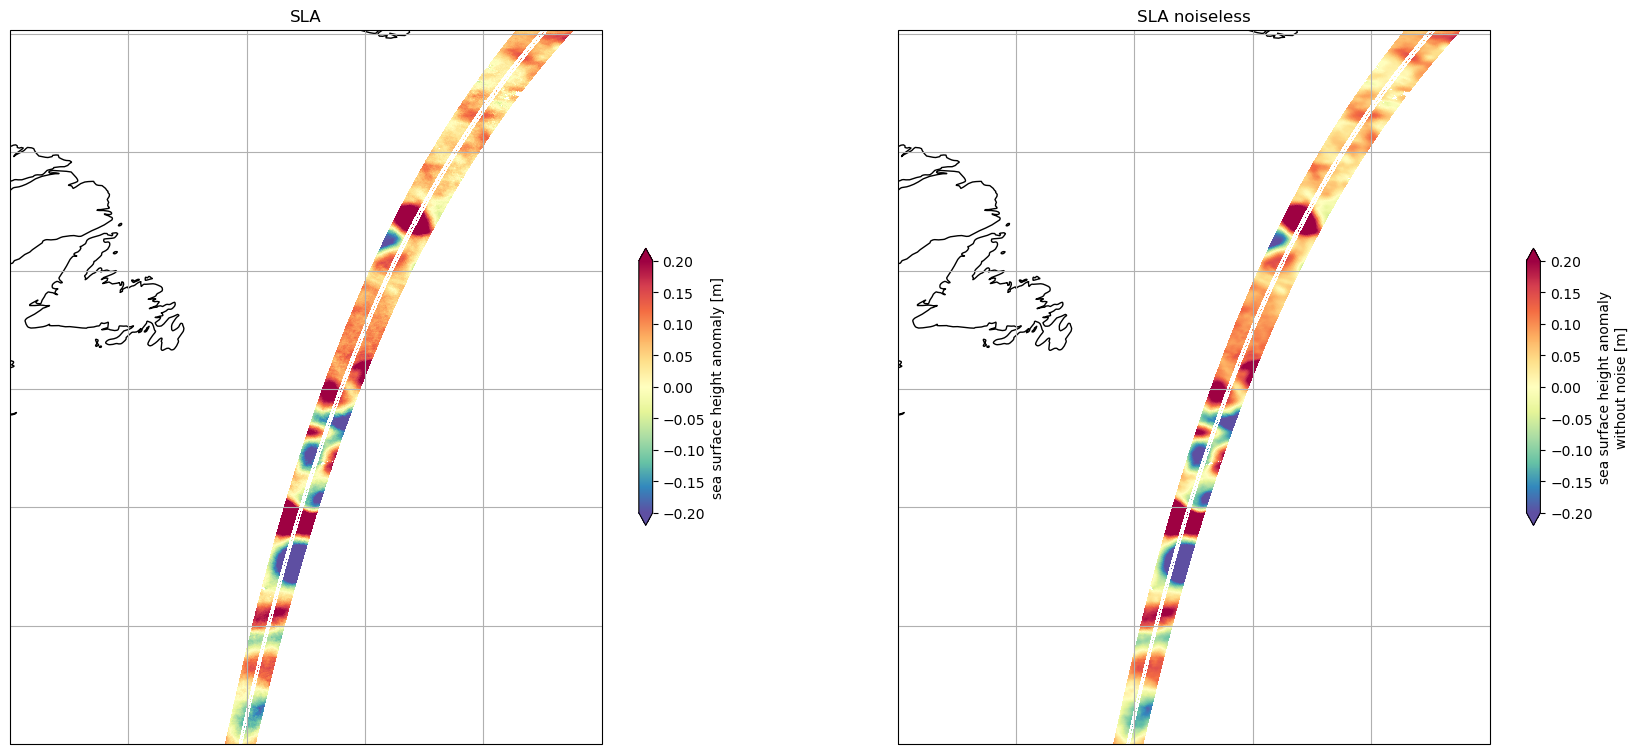

In [12]:
# set figures
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 12), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax1.set_extent(localbox)
ax2.set_extent(localbox)

plot_kwargs = dict(
    x="longitude",
    y="latitude",
    cmap="Spectral_r",
    vmin=-0.2,
    vmax=0.2,
    cbar_kwargs={"shrink": 0.3},)

# SWOT KaRIn SLA plots
ds_basic.ssha.plot.pcolormesh(ax=ax1, **plot_kwargs)
ds_basic.ssha_noiseless.plot.pcolormesh(ax=ax2, **plot_kwargs)

#
ax1.set_title("SLA")
ax1.coastlines()
ax1.gridlines()
ax2.set_title("SLA noiseless")
ax2.coastlines()
ax2.gridlines()

### 3.2 Plot sea level anomaly at nadir

The nadir data can be extracted from the dataset using the `i_num_line` and `i_num_pixel` indexes. The nadir positions and time are an estimation that combines the swath positions and time with the indexes.

In [13]:
ds_basic =  xr.open_dataset(half_orbit_basic)

ds_basic = ds_basic.assign_coords(longitude=(((ds_basic.longitude + 180) % 360) - 180))

# Build nadir variable
ds_basic["time_nadir"] = ds_basic.time[ds_basic.i_num_line]
ds_basic["longitude_nadir"] = ds_basic.longitude[ds_basic.i_num_line, ds_basic.i_num_pixel]
ds_basic["latitude_nadir"] = ds_basic.latitude[ds_basic.i_num_line, ds_basic.i_num_pixel]
ds_basic["sla_nadir"] = ds_basic.ssha[ds_basic.i_num_line, ds_basic.i_num_pixel]

# Select nadir data over the region (using num_nadir dimension only)
localsubset_nadir = (
(ds_basic.longitude_nadir > localbox[0]) &
(ds_basic.longitude_nadir < localbox[1]) &
(ds_basic.latitude_nadir > localbox[2]) &
(ds_basic.latitude_nadir < localbox[3]))

ds_nadir = ds_basic.drop_dims(["num_lines", "num_pixels"]).where(localsubset_nadir, drop=True)
ds_nadir

<xarray.Dataset>
Dimensions:          (num_nadir: 478)
Dimensions without coordinates: num_nadir
Data variables:
    i_num_line       (num_nadir) float32 6.616e+03 6.619e+03 ... 8.343e+03
    i_num_pixel      (num_nadir) float32 34.0 34.0 34.0 34.0 ... 34.0 34.0 34.0
    time_nadir       (num_nadir) datetime64[ns] 2024-06-10T07:13:37.865246848...
    longitude_nadir  (num_nadir) float64 -50.24 -50.23 -50.21 ... -37.63 -37.57
    latitude_nadir   (num_nadir) float64 30.07 30.12 30.19 ... 59.83 59.88 59.95
    sla_nadir        (num_nadir) float64 0.002 -0.003 0.0 ... 0.125 0.131 0.151
Attributes: (12/42)
    Conventions:                     CF-1.7
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea Surface Height measured by Altimetry
    data_used:                       SWOT KaRIn L2_LR_SSH PIC0 (NASA/CNES). D...
    doi:                             https://doi.org/10.24400/527896/A01-2023...
    ...                              ...
    time_coverage_begin:             2024-06-10T06:39:06Z
    time_coverage_end:               2024-06-10T07:30:32Z
    geospatial_lat_min:              -78.271942
    geospatial_lat_max:              78.272019
    geospatial_lon_min:              0.001003
    geospatial_lon_max:              359.999539

Text(0.5, 1.0, 'SLA Nadir')

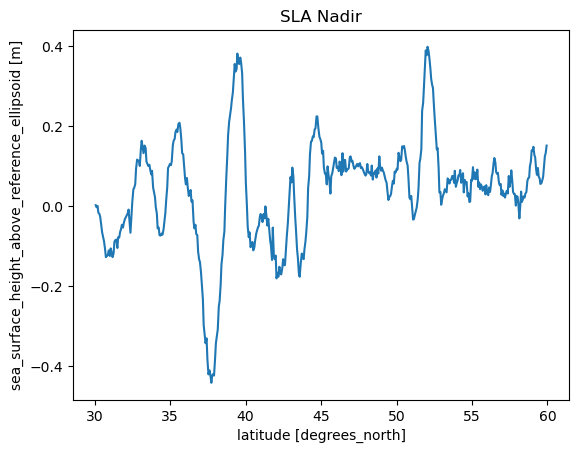

In [14]:
plt.plot(ds_nadir.latitude_nadir.values, ds_nadir.sla_nadir.values)
plt.ylabel(f'{ds_nadir.sla_nadir.attrs["standard_name"]} [{ds_nadir.sla_nadir.attrs["units"]}]')
plt.xlabel(f'{ds_nadir.latitude_nadir.attrs["standard_name"]} [{ds_nadir.latitude_nadir.attrs["units"]}]')
plt.title("SLA Nadir")

### 3.3 Remove sea level anomaly at nadir

It is possible to remove the nadir data combined with L3 KaRIn data.


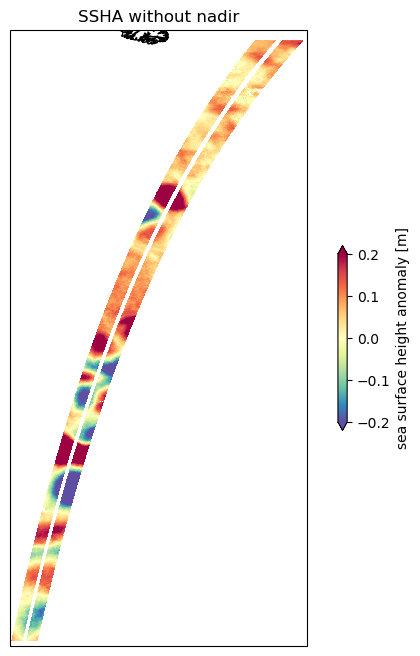

In [15]:
localsubset = (
    (ds_basic.longitude > localbox[0]) &
    (ds_basic.longitude < localbox[1]) &
    (ds_basic.latitude > localbox[2]) &
    (ds_basic.latitude < localbox[3])
)

# Masking must be done prior regional subsetting
ssha = ds_basic.ssha
ssha[ds_basic.i_num_line, ds_basic.i_num_pixel] = np.nan

# Regional subsetting
ssha_area = ssha.where(localsubset, drop=True)

# plot SLA KaRIn data only
#del plot_kwargs["cbar_kwargs"]
mesh = ssha_area.plot.pcolormesh(
figsize=(8, 8),
subplot_kws=dict(projection=ccrs.PlateCarree()),
**plot_kwargs)
mesh.axes.set_title("SSHA without nadir")
mesh.axes.coastlines()

## 4. Expert product



This product contains all the Basic fields, and additional fields that allow a deeper investigation by Expert users. This includes the corrections used for the SLA and the currents (absolute and relative) computed for the denoised SLA.

In [16]:
ds_expert = xr.open_dataset(half_orbit_expert)
[v for v in ds_expert.variables if v not in ds_basic]

['calibration',
 'cross_track_distance',
 'dac',
 'mss',
 'ocean_tide',
 'quality_flag',
 'sigma0',
 'ssha_unedited',
 'ugos',
 'ugosa',
 'vgos',
 'vgosa']

In [17]:
ds_expert = ds_expert.assign_coords(longitude=(((ds_expert.longitude + 180) % 360) - 180))

# Select data over the region
localsubset = (
(ds_expert.longitude > localbox[0]) &
(ds_expert.longitude < localbox[1]) &
(ds_expert.latitude > localbox[2]) &
(ds_expert.latitude < localbox[3]))

ds_expert_sub = ds_expert.where(localsubset, drop=True)
ds_expert_sub

<xarray.Dataset>
Dimensions:               (num_lines: 1756, num_pixels: 69, num_nadir: 1377)
Coordinates:
    latitude              (num_lines, num_pixels) float64 30.01 30.0 ... 59.99
    longitude             (num_lines, num_pixels) float64 -50.97 ... -36.2
Dimensions without coordinates: num_lines, num_pixels, num_nadir
Data variables: (12/18)
    time                  (num_lines, num_pixels) datetime64[ns] 2024-06-10T0...
    calibration           (num_lines, num_pixels) float64 nan -0.1054 ... nan
    cross_track_distance  (num_pixels, num_lines) float64 -68.0 -68.0 ... 68.0
    dac                   (num_lines, num_pixels) float32 -0.1081 ... -0.0704
    mdt                   (num_lines, num_pixels) float64 0.5407 ... -0.5379
    mss                   (num_lines, num_pixels) float64 -20.35 ... 52.91
    ...                    ...
    ugos                  (num_lines, num_pixels) float64 nan nan ... nan nan
    ugosa                 (num_lines, num_pixels) float64 nan nan ... nan nan
    vgos                  (num_lines, num_pixels) float64 nan nan ... nan nan
    vgosa                 (num_lines, num_pixels) float64 nan nan ... nan nan
    i_num_line            (num_nadir, num_lines, num_pixels) float32 1.217e+0...
    i_num_pixel           (num_nadir, num_lines, num_pixels) float32 34.0 ......
Attributes: (12/42)
    Conventions:                     CF-1.7
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea Surface Height measured by Altimetry
    data_used:                       SWOT KaRIn L2_LR_SSH PIC0 (NASA/CNES). D...
    doi:                             https://doi.org/10.24400/527896/A01-2023...
    ...                              ...
    time_coverage_begin:             2024-06-10T06:39:06Z
    time_coverage_end:               2024-06-10T07:30:32Z
    geospatial_lat_min:              -78.271942
    geospatial_lat_max:              78.272019
    geospatial_lon_min:              0.001003
    geospatial_lon_max:              359.999539

### 4.1 Sea level anomalies
Let's visualize SWOT KaRIn abd Nadir data using cartopy.
Adapt this code to visualize other variables or regions, or try importing another file.

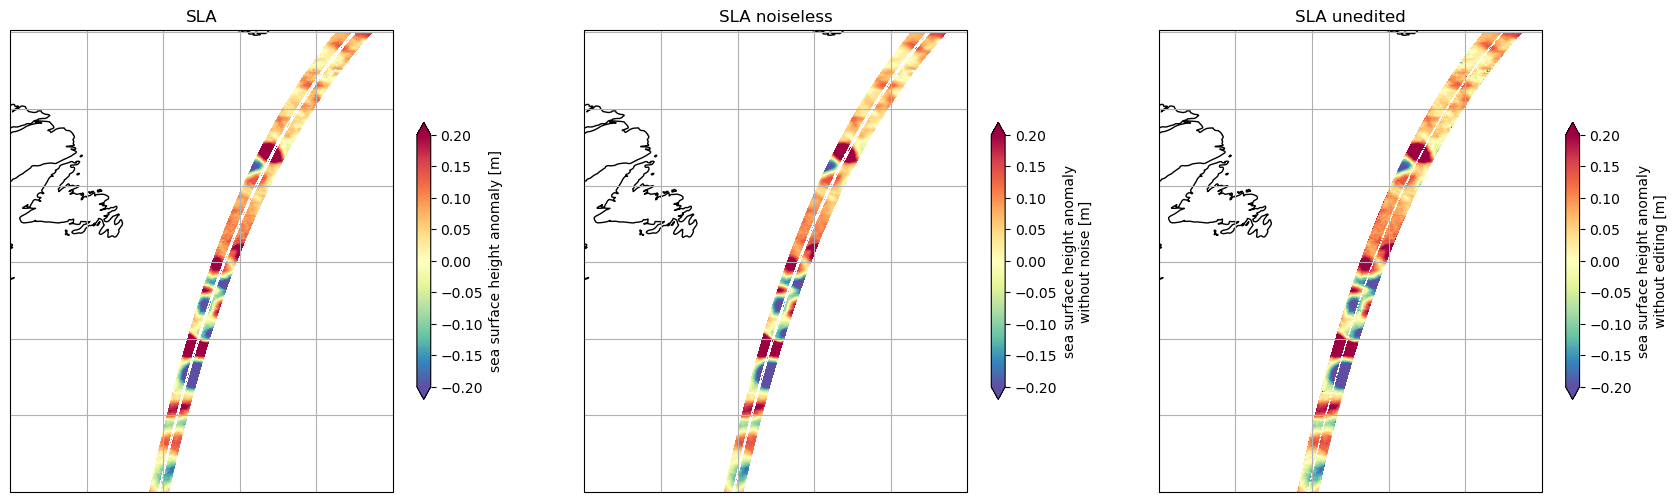

In [18]:
# set figure
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 12), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax1.set_extent(localbox)
ax2.set_extent(localbox)
ax3.set_extent(localbox)

plot_kwargs = dict(
    x="longitude",
    y="latitude",
    cmap="Spectral_r",
    vmin=-0.2,
    vmax=0.2,
    cbar_kwargs={"shrink": 0.3},)

# SWOT KaRIn SLA plots
ds_expert_sub.ssha.plot.pcolormesh(ax=ax1, **plot_kwargs)
ds_expert_sub.ssha_noiseless.plot.pcolormesh(ax=ax2, **plot_kwargs)
ds_expert_sub.ssha_unedited.plot.pcolormesh(ax=ax3, **plot_kwargs)

#
ax1.set_title("SLA")
ax1.coastlines()
ax1.gridlines()
ax2.set_title("SLA noiseless")
ax2.coastlines()
ax2.gridlines()
ax3.set_title("SLA unedited")
ax3.coastlines()
ax3.gridlines()

### 4.2 Sigma 0

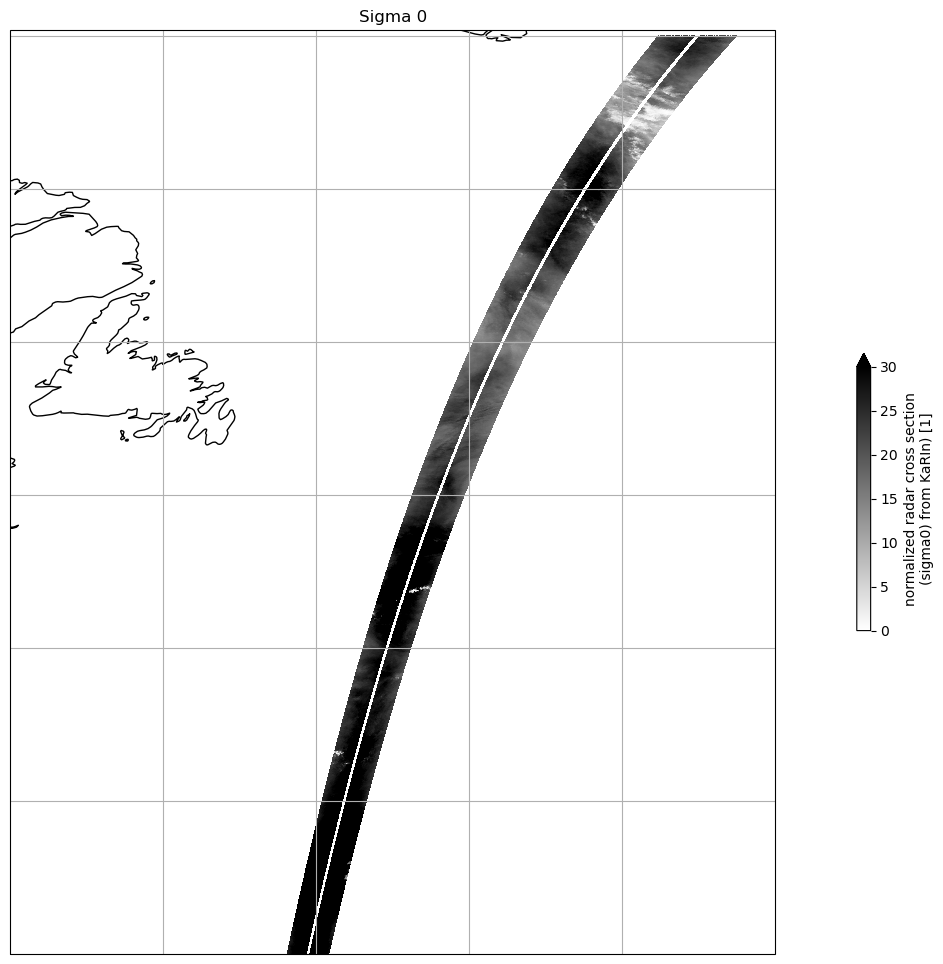

In [19]:
# set figure
fig, ax = plt.subplots(figsize=(21, 12), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.set_extent(localbox)

plot_kwargs = dict(
    x="longitude",
    y="latitude",
    cmap="gray_r",
    vmin=0,
    vmax=30,
    cbar_kwargs={"shrink": 0.3},)

# WOT KaRIn SLA plots
ds_expert_sub.sigma0.plot.pcolormesh(ax=ax, **plot_kwargs)

#
ax.set_title("Sigma 0")
ax.coastlines()
ax.gridlines()